In [1]:
from BIDS.snapshot2D import create_snapshot,Snapshot_Frame,Visualization_Type,Image_Modes
from pathlib import Path
from IPython.display import Image
import numpy as np
from BIDS import Centroids
from scipy import interpolate
import sys

WORKING_DIR = "/home/daniel/Documents/Uni/practical-sose23/"
HOME_DIR = "/home/daniel/"

sys.path.append(WORKING_DIR + "castellvi/3D-Castellvi-Prediction/src/utils")
from _prepare_data import *

from BIDS import BIDS_FILE, Centroids, Image_Reference, Centroid_Reference, NII
from BIDS.snapshot2D.snapshot_modular import Snapshot_Frame,create_snapshot, Visualization_Type
from pathlib import Path

####################################
/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  File "/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/daniel/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/daniel/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/home/daniel/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  File "/h

In [2]:
def fit_spline(centroids: Centroids, max_dim: int, smoothness: int=10) -> tuple[np.ndarray, np.ndarray]:
    """Makes a spline interpolation through the pointset and calculates the first derivative of the curve.

    Args:
        centroids: Given Centroids
        max_dim: int(max(img.shape))

    Returns:
        spline_points: np.array, spline_1stderivative: np.array
    """
    centroids_coords = list(centroids.sort().values())
    centroids_coords = np.asarray(centroids_coords)
    x_sample = centroids_coords[:, 0]
    y_sample = centroids_coords[:, 1]
    z_sample = centroids_coords[:, 2]
    tck, u = interpolate.splprep([x_sample,y_sample,z_sample], k=2, s=smoothness)
    u_fine = np.linspace(0, 1, max_dim)
    x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)
    xp_fine, yp_fine, zp_fine = interpolate.splev(u_fine, tck, der=1)
    #xp_fine = np.diff(x_fine)/np.diff(np.linspace(0, max(y_sample)-min(y_sample), max_dim))
    #xp_fine = np.concatenate((xp_fine, np.asarray([xp_fine[-1]])))
    #yp_fine = np.diff(y_fine)/np.diff(np.linspace(0, max(y_sample)-min(y_sample), max_dim))
    #yp_fine = np.concatenate((yp_fine, np.asarray([yp_fine[-1]])))
    #zp_fine = np.diff(z_fine)/np.diff(np.linspace(0, max(y_sample)-min(y_sample), max_dim))
    #zp_fine = np.concatenate((zp_fine, np.asarray([zp_fine[-1]])))#attach the last element missing after diff
    #if centroids.shape[0]>3:
    #     min_tilt_point, max_tilt_point = get_max_tilt(np.asarray([x_fine, y_fine, z_fine]), np.asarray([xp_fine, yp_fine, zp_fine]))
    return np.asarray(list(zip(x_fine, y_fine, z_fine))), np.asarray(list(zip(xp_fine, yp_fine, zp_fine)))

In [3]:
WORKING_DIR = "/home/daniel/Documents/Uni/practical-sose23/"
dataset = [WORKING_DIR  + 'dataset-verse19',  WORKING_DIR + 'dataset-verse20', WORKING_DIR + 'dataset-tri']
data_types = ['rawdata',"derivatives"]
image_types = ["ct", "subreg", "cortex"]
master_list = WORKING_DIR + 'castellvi/3D-Castellvi-Prediction/src/dataset/Castellvi_list_v3.xlsx'
processor = DataHandler(master_list=master_list ,dataset=dataset, data_types=data_types, image_types=image_types)

[!] Unknown format seg-ano in file sub-verse602_dir-iso_seg-ano.nii.gz
[!] Unknown format iso-ctd in file sub-verse616_dir-iso_iso-ctd.json
[!] Unknown format subreg in file sub-verse559_CT-sag_seg-ano_subreg.nii.gz
[!] Unknown format ce-pv in file sub-tri087_ce-pv.nii.gz
[!] Unknown format ce-ar in file sub-tri129_ce-ar.nii.gz
[!] Unknown format ce-late in file sub-tri023_ce-late.nii.gz
[!] Unknown format ce-ne in file sub-tri026_ce-ne.nii.gz
[!] Unknown format stat in file sub-tri087_ce-ne_seg-total_stat.json


In [4]:
def calculate_angle_dist(ctd: Centroids):
    last_L = 25 if 25 in ctd.centroids.keys() else 24 if 24 in ctd.centroids.keys() else 23 if 23 in ctd.centroids.keys() else None
    assert(last_L is not None)
    prev_L = last_L - 1
    sac = 26

    assert(prev_L in ctd.centroids.keys())
    assert(sac in ctd.centroids.keys())

    v1 = np.asarray(ctd.centroids[last_L]) - np.asarray(ctd.centroids[prev_L])
    v2 = np.asarray(ctd.centroids[last_L]) - np.asarray(ctd.centroids[sac])

    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

    #calculate distance between last_L and sac
    dist = np.linalg.norm(np.asarray(ctd.centroids[last_L]) - np.asarray(ctd.centroids[sac]))

    return angle, dist

def calculate_max_der(ctd: Centroids):
    spline, spline_der = fit_spline(ctd, 128)
    max_der = np.max(np.linalg.norm(spline_der, axis=1))
    return max_der

In [11]:
angles = []
labels = []
records = []
distances = []
max_ders = []

castellvi_encoding = {
    '0': 0,
    '1a': 10,
    '1b': 11,
    '2a': 20,
    '2b': 21,
    '3a': 30,
    '3b': 31,
    '4': 40,
}

for record in processor.verse_records + processor.tri_records:
    ctd = record["ctd_file"].open_cdt()
    ct = record["raw_file"].open_nii()
    ctd.zoom = ct.zoom
    if not ctd.shape:
        ctd.shape = ct.shape
    ctd = ctd.rescale((1,1,1), verbose=False)
    if not record["flip"]:
        try:
            angle, dist = calculate_angle_dist(ctd)
            if dist < 20:
                continue
            angles.append(angle)
            distances.append(dist)
            max_ders.append(calculate_max_der(ctd))
            labels.append(castellvi_encoding[record['castellvi']])
            records.append(record)
        except:
            print("Error in record: ", record['subject'])

In [6]:
# Print count of each label
print("Count of each label: ", np.unique(labels, return_counts=True))

Count of each label:  (array([ 0, 20, 21, 30, 31, 40]), array([322,  45,  29,  18,  31,   8]))


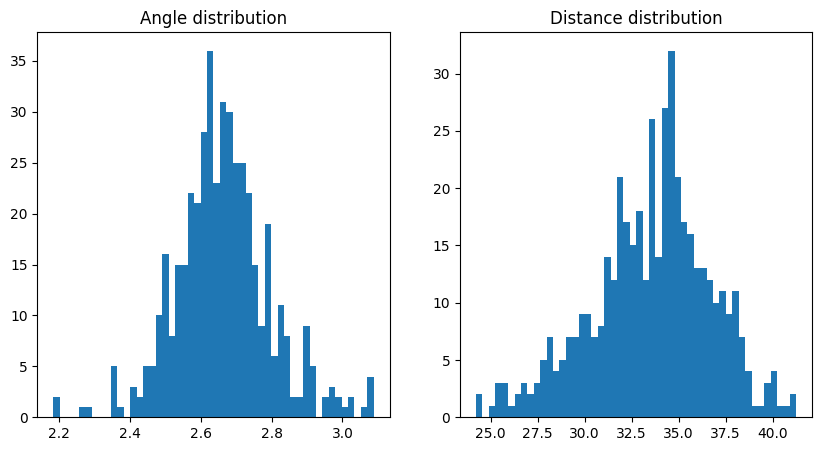

In [7]:
# Plot dsitribtion of angles and distances side by side
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(angles, bins=50)
axs[0].set_title("Angle distribution")
axs[1].hist(distances, bins=50)
axs[1].set_title("Distance distribution")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


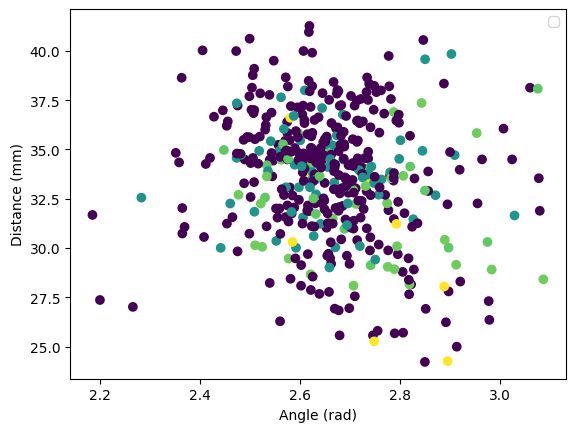

In [8]:
#Plot angle-distance as scatter plot colored by label with legend for color coding
scatter = plt.scatter(angles, distances, c=labels)
plt.xlabel("Angle (rad)")
plt.ylabel("Distance (mm)")
plt.legend()
plt.show()

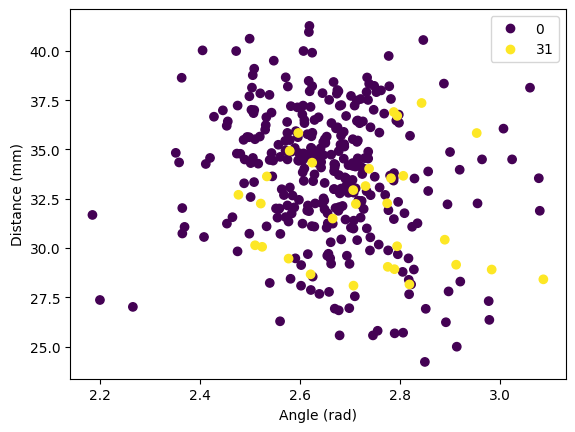

In [9]:
#Plot angle-distance as scatter plot colored by label with legend for color coding
labels = np.asarray(labels)
angles = np.asarray(angles)
distances = np.asarray(distances)
max_ders = np.asarray(max_ders)

idx_0 = np.where(labels == 0)
idx_31 = np.where(labels == 31)

idx = np.concatenate((idx_0[0], idx_31[0]))

scatter = plt.scatter(angles[idx], distances[idx], c=labels[idx])
plt.xlabel("Angle (rad)")
plt.ylabel("Distance (mm)")
plt.legend(*scatter.legend_elements())
plt.show()

In [10]:
#fit two-dimensional logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

X = np.asarray(list(zip(angles, distances)))
y = np.asarray(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion matrix: ", confusion_matrix(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print("Average precision score: ", average_precision_score(y_test, y_pred))


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



####################################
/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  File "/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/daniel/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File 

Accuracy:  0.7692307692307693
Confusion matrix:  [[70  0  0  0  0  0]
 [ 8  0  0  0  0  0]
 [ 4  0  0  0  0  0]
 [ 2  0  0  0  0  0]
 [ 6  0  0  0  0  0]
 [ 1  0  0  0  0  0]]


ValueError: multi_class must be in ('ovo', 'ovr')

####################################
/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
  File "/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/daniel/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/daniel/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/home/daniel/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  Fi

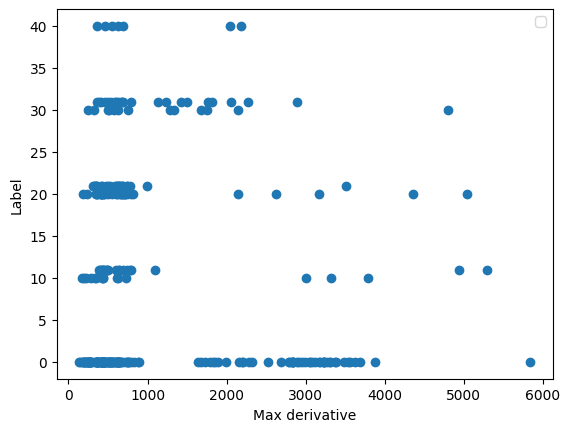

In [ ]:
#Plot max_der by label
scatter = plt.scatter(max_ders, labels)
plt.xlabel("Max derivative")
plt.ylabel("Label")
plt.legend(*scatter.legend_elements())
plt.show()

The AUC score indicates a performance that is only a tiny bit better than random choice. We conclude that the angle between the last vertebrae alone is not indicative enough of the true castellvi label.

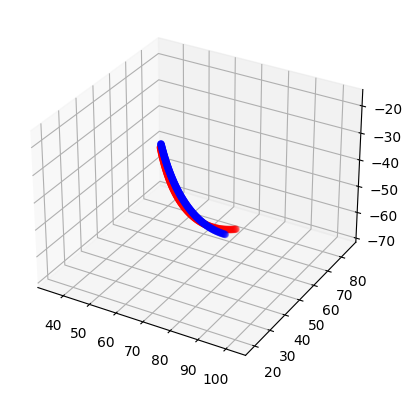

In [ ]:
#get a record with label 0 and 31
idx = np.where(np.asarray(labels) == 0)[0][2]
record_0 = records[idx]
angle_0 = angles[idx]
dist_0 = distances[idx]
idx = np.where(np.asarray(labels) == 31)[0][3]
record_31 = records[idx]
angle_31 = angles[idx]
dist_31 = distances[idx]

ct_0, seg_0, ctd_0 = processor.get_ct_seg_ctd_cutout(record_0)
ct_31, seg_31, ctd_31 = processor.get_ct_seg_ctd_cutout(record_31)

spline_0, spline_0_der = fit_spline(ctd_0, max_dim = 128)
spline_31, spline_31_der = fit_spline(ctd_31, max_dim = 128)


# Plot spline_0 and spline_31
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(spline_0[:,2], spline_0[:,0], -spline_0[:,1], c='r', marker='o')
ax.scatter3D(spline_31[:,2], spline_31[:,0], -spline_31[:,1], c='b', marker='o')
ax.axis('equal')
plt.show()


In [ ]:
# Print angle and distance for 0 and 31 cases
print("Angle for 0 case: ", angle_0)
print("Distance for 0 case: ", dist_0)
print("Angle for 31 case: ", angle_31)
print("Distance for 31 case: ", dist_31)

Angle for 0 case:  2.6292596135783635
Distance for 0 case:  33.734255586866
Angle for 31 case:  2.776073373949158
Distance for 31 case:  29.048956711042138


In [ ]:
# calculate the maximum norm of the first derivative of the splines
print("Maximum norm of the first derivative of the spline 0: ", np.max(np.linalg.norm(spline_0_der, axis=1)))
print("Maximum norm of the first derivative of the spline 31: ", np.max(np.linalg.norm(spline_31_der, axis=1)))

Maximum norm of the first derivative of the spline 0:  71.71625675494677
Maximum norm of the first derivative of the spline 31:  65.73678567424706
